In [1]:
import pandas as pd
import pickle
from codecs import getdecoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import re
import regex
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from string import punctuation
from gensim.models.phrases import Phrases, Phraser
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.extmath import randomized_svd
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import spacy
import seaborn as sns
from gensim import corpora, models, similarities, matutils, models#
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.mixture import GaussianMixture

%matplotlib inline

In [2]:
nlp = spacy.load('en')

In [3]:
with open("fixed_df.pkl", 'rb') as picklefile: 
    df2 = pickle.load(picklefile)

In [4]:
df2.head()

,date,location,paragraph,title,dt
3,"January 17, 2017",James S. Brady Press Briefing Room,"MR. EARNEST Good afternoon, everybody. I dont ...",Press Briefing by Press Secretary Josh Earnest...,2017-01-17
4,"January 17, 2017",James S. Brady Press Briefing Room,Q Thank you. Laughter.,Press Briefing by Press Secretary Josh Earnest...,2017-01-17
5,"January 17, 2017",James S. Brady Press Briefing Room,MR. EARNEST But because today marks my last br...,Press Briefing by Press Secretary Josh Earnest...,2017-01-17
6,"January 17, 2017",James S. Brady Press Briefing Room,As I prepared to stand here at this podium for...,Press Briefing by Press Secretary Josh Earnest...,2017-01-17
7,"January 17, 2017",James S. Brady Press Briefing Room,I had been in D.C. for a grand total of two we...,Press Briefing by Press Secretary Josh Earnest...,2017-01-17


In [5]:
doc_list = df2.paragraph.tolist()

In [6]:
len(doc_list)

121562

In [7]:
#doc_list[:10]

## entity extraction and stemming

In [8]:
def underscore_entities(documents):
    
    docs = []
    for i in documents:
        docs.append(nlp(i))
    
    uds_entities = []

    for para in docs:

        ent_chars = []
        for i in para.ents:
            ent_chars.append((i.start_char, i.end_char))
        #print(para.ents)
        #print(ent_chars)
        
        new_string = []
        for index, item in enumerate(list(str(para))):
            for i, j in enumerate(ent_chars):
                if j[0] < index < j[1] and item == ' ':
                    item = '_'
            new_string.append(item)

        ns = ''.join(new_string)
        uds_entities.append(ns)
        
    return uds_entities

In [9]:
def lancaster_stem(doc):
    stems = []
    for line in doc:
        doc_stems = []
        tokens = word_tokenize(line)
        for item in tokens:
            doc_stems.append(LancasterStemmer().stem(item))
        stems.append(' '.join(doc_stems))
    return stems

In [10]:
test = doc_list[:5000]

##  tfidf vecs

tfidf and lancaster seem to be the best

In [11]:
# note test is currently at 5000
# stemmed_ents = lancaster_stem(underscore_entities(test))
# full data
stemmed_ents = lancaster_stem(underscore_entities(doc_list))

In [12]:
tfidf = TfidfVectorizer(stop_words = "english", min_df = 5)
vecs = tfidf.fit_transform(stemmed_ents)

In [13]:
tfidf_df = pd.DataFrame(vecs.todense(), columns=tfidf.get_feature_names())
tfidf_df.shape

(121562, 9350)

In [14]:
terms = tfidf.get_feature_names()

In [15]:
terms

['99',
 '9999',
 '9999_a',
 '9999_p',
 '99_a_year',
 '99_americans',
 '99_an_hour',
 '99_and',
 '99_and_99',
 '99_billion',
 '99_billion_investment',
 '99_cents',
 '99_commission',
 '99_consecutive_months',
 '99_days',
 '99_days_ago',
 '99_days_or_so_ago',
 '99_feet',
 '99_hours',
 '99_hours_ago',
 '99_in',
 '99_is',
 '99_kilometers',
 '99_miles',
 '99_million',
 '99_million_a',
 '99_million_acres',
 '99_million_barrels',
 '99_minutes',
 '99_months',
 '99_months_ago',
 '99_national_medal_of_arts',
 '99_or',
 '99_or_99',
 '99_or_99_minutes',
 '99_or_99_years',
 '99_or_more',
 '99_or_so',
 '99_p',
 '99_per_month',
 '99_perc',
 '99_percent',
 '99_straight_months',
 '99_to',
 '99_to_99',
 '99_to_99_months',
 '99_trillion',
 '99_troops',
 '99_weeks',
 '99_years',
 '99_years_ago',
 '99_years_later',
 '99_years_old',
 '99c99',
 '99d',
 '99day',
 '99day_period',
 '99gun',
 '99hour',
 '99k',
 '99kilometer',
 '99member',
 '99milelong',
 '99minute',
 '99month',
 '99nd',
 '99page',
 '99percent',
 

In [16]:
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

## LSA (sklearn) + kmeans / dbscan / agglomerative clustering / spectral / gaussian mixture

**SVD + normalize**

In [17]:
lsa = TruncatedSVD(200, algorithm = 'arpack')
lsa_vecs = lsa.fit_transform(vecs)
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)

**kmeans**

In [18]:
cluster_num = 80
km = KMeans(n_clusters = cluster_num)
km.fit(lsa_vecs)

# predict one cluster per document
predicted_cluster = km.predict(lsa_vecs)

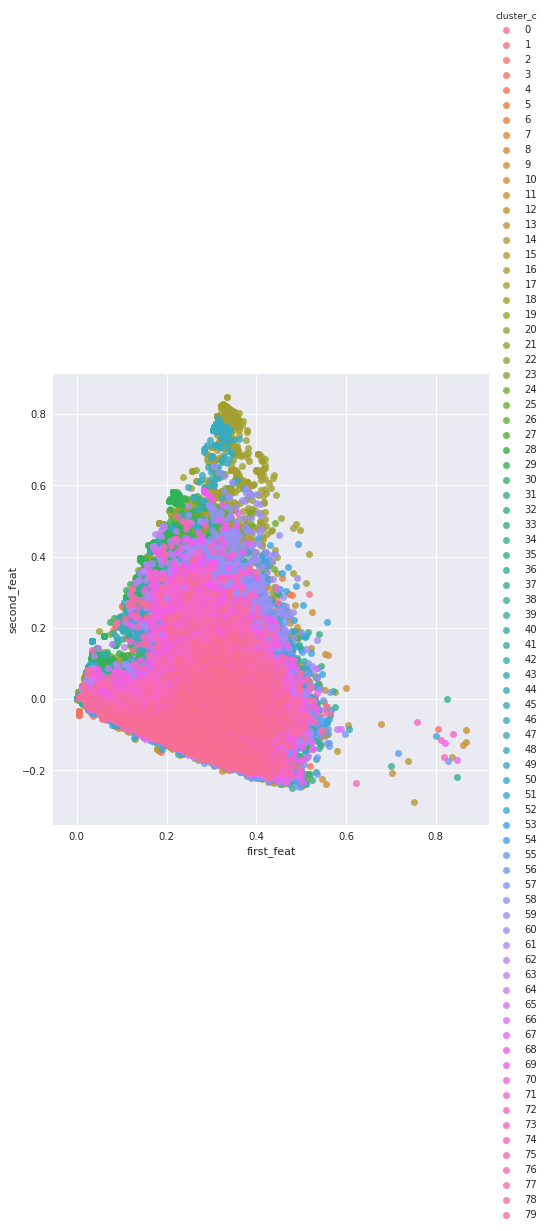

In [19]:
df = pd.DataFrame(lsa_vecs[:,0:2], columns = ['first_feat', 'second_feat'])
df['cluster_c'] = predicted_cluster

sns.lmplot(x = 'first_feat', y='second_feat', hue = 'cluster_c', data = df, fit_reg = False, size = 7)

In [20]:
#lsa.explained_variance_ratio_

In [21]:
original_space_centroids = lsa.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [39]:
for i in range(cluster_num):
    print("Cluster %d:" % i, end='')
    print(" ")
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')  # print words in clusters
        print("")
    print(" ")
    print(" ")
print()

Cluster 0: 
 prim
 min
 israel
 presid
 netanyahu
 ind
 visit
 thi
 wil
 hav
 rel
 obam
 meet
 lead
 the_united_states
 mr
 cal
 mod
 sec
 wel
 
 
Cluster 1: 
 report
 seen
 hav
 mr
 thi
 ther
 releas
 iv
 earnest
 presid
 confirm
 thos
 ar
 som
 wel
 say
 carney
 wer
 read
 com
 
 
Cluster 2: 
 isil
 jon
 fight
 strategy
 syr
 coalit
 hav
 threat
 milit
 ar
 iraq
 effort
 forc
 thi
 ultim
 ter
 degrad
 tak
 destroy
 success
 
 
Cluster 3: 
 aboard
 chris
 air_force_one
 start
 just
 say
 want
 cheryl
 justin
 ed
 jeff
 wel
 mor
 follow
 mean
 lik
 ev
 today
 al
 cal
 
 
Cluster 4: 
 discuss
 issu
 presid
 hav
 thi
 wil
 ther
 mr
 wel
 meet
 ar
 opportun
 think
 som
 lead
 thos
 im
 wev
 rel
 earnest
 
 
Cluster 5: 
 ask
 quest
 im
 mr
 presid
 just
 hav
 want
 yo
 thi
 earnest
 wel
 carney
 ar
 think
 wer
 say
 spec
 ther
 going
 
 
Cluster 6: 
 tim
 thi
 presid
 hav
 som
 mr
 ther
 long
 sam
 earnest
 think
 mor
 ar
 wer
 say
 just
 spend
 wil
 al
 talk
 
 
Cluster 7: 
 did
 presid
 

In [40]:
# this run
# 79 = iraq
# 76 = afghanistan
# 75 = russia/ukraine
# 73 = senate nomination
# 66 = syria
# 65 = congress
# 64 = national security
# 63 = fbi investigation
# 61 = clinton emails
# 53 = healthcare
# 49 = iran nuclear deal
# 41 = iran sanctions
# 15 = law enforcement
# 12 = end wars
# 11 = economy
# 9 = immigration reform
# 8 = bills/legislation/congress
# 2 = isis
# 0 = israel

In [24]:
# smaller dataset gives clusters on:

# congress, north korea, russia/trump, cuba, russia/intelligence, transition, economy, health, econ, iraq

In [26]:
cluster_words = []
for i in range(cluster_num):
    words = []
    for ind in order_centroids[i, :20]:
        words.append(terms[ind])
    cluster_words.append(words)

In [27]:
cluster_words = pd.DataFrame(np.reshape(cluster_words, (80, 20)))

In [28]:
cluster_words.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,prim,min,israel,presid,netanyahu,ind,visit,thi,wil,hav,rel,obam,meet,lead,the_united_states,mr,cal,mod,sec,wel
1,report,seen,hav,mr,thi,ther,releas,iv,earnest,presid,confirm,thos,ar,som,wel,say,carney,wer,read,com
2,isil,jon,fight,strategy,syr,coalit,hav,threat,milit,ar,iraq,effort,forc,thi,ultim,ter,degrad,tak,destroy,success
3,aboard,chris,air_force_one,start,just,say,want,cheryl,justin,ed,jeff,wel,mor,follow,mean,lik,ev,today,al,cal
4,discuss,issu,presid,hav,thi,wil,ther,mr,wel,meet,ar,opportun,think,som,lead,thos,im,wev,rel,earnest


In [29]:
cluster_words.to_csv('words_per_cluster_3.csv')

In [30]:
df.tail()

,first_feat,second_feat,cluster_c
121557,0.258767,-0.118106,73
121558,0.344674,-0.160162,27
121559,0.270311,-0.087345,52
121560,0.084872,0.005574,20
121561,0.018795,-0.017275,12


In [31]:
df2 = df2.reset_index()

In [32]:
merged_df = pd.concat([df2, df], axis = 1)

In [33]:
merged_df['week_start']=merged_df['dt']-pd.DateOffset(weekday=0,weeks=1)

/home/emily/anaconda3/lib/python3.6/site-packages/pandas/tseries/index.py:817: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


In [34]:
cluster_df_long = merged_df.groupby(['week_start', 'cluster_c'])['paragraph'].count().reset_index()

In [35]:
cluster_df = cluster_df_long.pivot(index='week_start', columns='cluster_c', values='paragraph').reset_index()

In [36]:
cluster_df.fillna(0, inplace = True)

In [37]:
cluster_df.head()

cluster_c,week_start,0,1,2,3,4,5,6,7,8,...,70,71,72,73,74,75,76,77,78,79
0,2013-01-21,8.0,6.0,1.0,30.0,0.0,6.0,5.0,8.0,9.0,...,0.0,9.0,14.0,9.0,8.0,0.0,4.0,15.0,0.0,0.0
1,2013-01-28,1.0,10.0,0.0,38.0,6.0,6.0,5.0,8.0,3.0,...,0.0,7.0,8.0,32.0,14.0,0.0,3.0,7.0,1.0,1.0
2,2013-02-04,1.0,2.0,2.0,38.0,14.0,11.0,12.0,2.0,5.0,...,1.0,5.0,8.0,15.0,7.0,0.0,2.0,15.0,2.0,0.0
3,2013-02-11,0.0,3.0,0.0,11.0,5.0,1.0,4.0,0.0,2.0,...,1.0,2.0,12.0,23.0,6.0,0.0,2.0,4.0,0.0,0.0
4,2013-02-18,4.0,17.0,5.0,37.0,4.0,5.0,7.0,2.0,11.0,...,3.0,9.0,6.0,19.0,5.0,0.0,0.0,10.0,2.0,0.0


In [38]:
cluster_df.to_csv('lsa_kmeans_cluster_3.csv')